# Overview

In this notebook, the objective is to improve upon the baseline model as much as possible. To do this, many untuned models will be tried to find the one that performs the best. From there, the best performing model will be tuned to optimize its performance. Here's what was done:

1. [Imports](#Imports)
2. [Data Prep](#Data-Prep)  
    a. [TF-IDF](#Unigram-TF-IDF-Vectorizer)  
    b. [Doc2Vec](#Doc2Vec)  
3. [Choosing Best Model](#Choosing-Best-Model)
4. [Tuning Best Model](#TF-IDF-Logistic-Regression-Parameter-Tuning)
5. [Pickling Best Model](#Pickling-Best-Model)

# Imports

In [1]:
# All necessary modules and packages
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report, plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import ComplementNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import recall_score, accuracy_score, f1_score
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from xgboost import XGBClassifier

import gensim
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import warnings
%matplotlib inline
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', 1000)

# Reading in data
data = pd.read_csv('./data_collection/prepared_twitter_sentiment_data.csv', index_col=0)
# Drop 31 rows with missing message column
data.dropna(inplace=True)
# Reassigning target variable names to remove negative
data.sentiment = data.sentiment.apply(lambda x: 'anti' if x == -1 else x)
data.sentiment = data.sentiment.apply(lambda x: 'neutral' if x == 0 else x)
data.sentiment = data.sentiment.apply(lambda x: 'man' if x == 1 else x)
data.sentiment = data.sentiment.apply(lambda x: 'news' if x == 2 else x)

# Data Prep

## Unigram TF-IDF Vectorizer

In [5]:
X = data.drop(columns = 'sentiment')
y = data.sentiment

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.20, 
                                                    random_state=1)

In [6]:
# Instantiate vectorizer
tfidf = TfidfVectorizer(ngram_range= (1,1))
# Fit to training data
tfidf_train = tfidf.fit_transform(X_train.message)
# Transform test data
tfidf_test = tfidf.transform(X_test.message)

In [7]:
# Convert vectors to dataframe
tfidf_train_df = pd.DataFrame.sparse.from_spmatrix(
    tfidf_train, columns=tfidf.get_feature_names())
tfidf_test_df = pd.DataFrame.sparse.from_spmatrix(
    tfidf_test, columns=tfidf.get_feature_names())

## Adding Engineered Features

In [8]:
# Extracting just features from dataframe
tfidf_train_features = X_train.drop(columns='message')
tfidf_test_features = X_test.drop(columns='message')

# Reset index to match tfidf dataframe
tfidf_train_features.reset_index(drop=True, inplace=True)
tfidf_test_features.reset_index(drop=True, inplace=True)

In [9]:
# Combining tfidf with custom features
tfidf_train_featured = tfidf_train_df.join(tfidf_train_features, how='outer')
tfidf_test_featured = tfidf_test_df.join(tfidf_test_features, how='outer')

## Doc2Vec

In [12]:
# Performing train test split including target variable
train, test = train_test_split(data, test_size=0.2, random_state=42)

In [13]:
# Separating target variables from train and test
y_train_doc = train.sentiment
y_test_doc = test.sentiment

In [14]:
# Tokenizing and tagging each observation message column
train_docs = train.apply(lambda x: TaggedDocument(words=x.message.split(), tags=[x.sentiment]), axis=1)

In [15]:
# Tokenizing train and test data
train_data = [tweet.split() for tweet in train['message']]
test_data = [tweet.split() for tweet in test['message']]

In [16]:
%%time

# training Doc2Vec
model = Doc2Vec(vector_size=10, 
                alpha=0.025, 
                min_count=5,
                epochs=100)

model.build_vocab(train_docs)
model.train(train_docs, 
            total_examples=model.corpus_count, 
            epochs=model.epochs)

CPU times: user 3min 5s, sys: 37.6 s, total: 3min 43s
Wall time: 2min 54s


In [17]:
%%time

# infer in multiple steps to get a stable representation 
train_vecs = [model.infer_vector(words, epochs=100) \
              for words in train_data]
test_vecs = [model.infer_vector(words, epochs=100) \
             for words in test_data]

CPU times: user 2min 27s, sys: 1.58 s, total: 2min 28s
Wall time: 2min 37s


In [18]:
%%time

# convert both sets to dataframe
doc_train_df = pd.DataFrame(train_vecs, columns=[
    f'docvec_{i}' for i in range(1,11)
])

doc_test_df = pd.DataFrame(test_vecs, columns=[
    f'docvec_{i}' for i in range(1,11)
])

CPU times: user 139 ms, sys: 10.5 ms, total: 150 ms
Wall time: 182 ms


### Adding Engineered Features

In [19]:
# Extracting just features from dataframe
train_features = train.drop(columns=['sentiment','message'])
test_features = test.drop(columns=['sentiment','message'])

# Reset index to match doc2vec dataframe
train_features.reset_index(drop=True, inplace=True)
test_features.reset_index(drop=True, inplace=True)

In [20]:
# Combining Doc2Vec with custom features
doc_train_featured = doc_train_df.join(train_features, how='outer')
doc_test_featured = doc_test_df.join(test_features, how='outer')

# Choosing Best Model

## Unigram TF-IDF Vectorizer

### Without Features Added

#### Random Forest

In [93]:
# Instantiate Classifier
rf_tfidf = RandomForestClassifier()
# Fit to training data
rf_tfidf.fit(tfidf_train_df, y_train)
# Predict on testing data
rf_tfidf_preds = rf_tfidf.predict(tfidf_test_df)
# Evaluating with classification report
print(classification_report(y_test, rf_tfidf_preds))

              precision    recall  f1-score   support

        anti       0.78      0.32      0.45       823
         man       0.68      0.89      0.77      4526
     neutral       0.59      0.37      0.46      1549
        news       0.75      0.60      0.67      1885

    accuracy                           0.68      8783
   macro avg       0.70      0.55      0.59      8783
weighted avg       0.69      0.68      0.66      8783



#### Logistic Regression

In [8]:
# Instantiate Classifier
lr_tfidf = LogisticRegression()
# Fit to training data
lr_tfidf.fit(tfidf_train_df, y_train)
# Predict on testing data
lr_tfidf_preds = lr_tfidf.predict(tfidf_test_df)
# Evaluating with classification report
print(classification_report(y_test, lr_tfidf_preds))

              precision    recall  f1-score   support

        anti       0.73      0.41      0.52       823
         man       0.71      0.87      0.78      4526
     neutral       0.63      0.43      0.51      1549
        news       0.73      0.66      0.69      1885

    accuracy                           0.70      8783
   macro avg       0.70      0.59      0.63      8783
weighted avg       0.70      0.70      0.69      8783



#### Multinomial Naive Bayes

In [10]:
# Instantiate Classifier
mnb_tfidf = MultinomialNB()
# Fit to training data
mnb_tfidf.fit(tfidf_train_df, y_train)
# Predict on testing data
mnb_tfidf_preds = mnb_tfidf.predict(tfidf_test_df)
# Evaluating with classification report
print(classification_report(y_test, mnb_tfidf_preds))

              precision    recall  f1-score   support

        anti       0.91      0.06      0.12       823
         man       0.58      0.98      0.73      4526
     neutral       0.84      0.08      0.15      1549
        news       0.82      0.39      0.53      1885

    accuracy                           0.61      8783
   macro avg       0.79      0.38      0.38      8783
weighted avg       0.71      0.61      0.52      8783



#### Complement Naive Bayes

In [99]:
# Instantiate Classifier
cnb_tfidf = ComplementNB()
# Fit to training data
cnb_tfidf.fit(tfidf_train_df, y_train)
# Predict on testing data
cnb_tfidf_preds = cnb_tfidf.predict(tfidf_test_df)
# Evaluating with classification report
print(classification_report(y_test, cnb_tfidf_preds))

              precision    recall  f1-score   support

        anti       0.57      0.47      0.51       823
         man       0.73      0.80      0.76      4526
     neutral       0.60      0.36      0.45      1549
        news       0.63      0.73      0.67      1885

    accuracy                           0.68      8783
   macro avg       0.63      0.59      0.60      8783
weighted avg       0.67      0.68      0.67      8783



#### Bernoulli Naive Bayes

In [100]:
# Instantiate Classifier
bnb_tfidf = BernoulliNB()
# Fit to training data
bnb_tfidf.fit(tfidf_train_df, y_train)
# Predict on testing data
bnb_tfidf_preds = bnb_tfidf.predict(tfidf_test_df)
# Evaluating with classification report
print(classification_report(y_test, bnb_tfidf_preds))

              precision    recall  f1-score   support

        anti       0.75      0.24      0.36       823
         man       0.67      0.85      0.75      4526
     neutral       0.53      0.39      0.45      1549
        news       0.71      0.62      0.66      1885

    accuracy                           0.66      8783
   macro avg       0.67      0.53      0.56      8783
weighted avg       0.66      0.66      0.64      8783



### With Features Added

#### Random Forest

In [12]:
# Instantiate Classifier
rf_tfidf_featured = RandomForestClassifier()
# Fit to training data
rf_tfidf_featured.fit(tfidf_train_featured, y_train)
# Predict on testing data
rf_tfidf_featured_preds = rf_tfidf_featured.predict(tfidf_test_featured)
# Evaluating with classification report
print(classification_report(y_test, rf_tfidf_featured_preds))

              precision    recall  f1-score   support

        anti       0.89      0.19      0.31       823
         man       0.65      0.93      0.77      4526
     neutral       0.71      0.34      0.46      1549
        news       0.81      0.61      0.70      1885

    accuracy                           0.69      8783
   macro avg       0.76      0.52      0.56      8783
weighted avg       0.72      0.69      0.66      8783



#### Logistic Regression

In [10]:
# Instantiate Classifier
lr_tfidf_featured = LogisticRegression()
# Fit to training data
lr_tfidf_featured.fit(tfidf_train_featured, y_train)
# Predict on testing data
lr_tfidf_featured_preds = lr_tfidf_featured.predict(tfidf_test_featured)
# Evaluating with classification report
print(classification_report(y_test, lr_tfidf_featured_preds))

              precision    recall  f1-score   support

        anti       0.43      0.01      0.01       823
         man       0.59      0.86      0.70      4526
     neutral       0.54      0.19      0.28      1549
        news       0.51      0.45      0.48      1885

    accuracy                           0.57      8783
   macro avg       0.52      0.38      0.37      8783
weighted avg       0.55      0.57      0.52      8783



#### Bernoulli Naive Bayes

In [11]:
# Instantiate Classifier
bnb_tfidf_featured = BernoulliNB()
# Fit to training data
bnb_tfidf_featured.fit(tfidf_train_featured, y_train)
# Predict on testing data
bnb_tfidf_featured_preds = bnb_tfidf_featured.predict(tfidf_test_featured)
# Evaluating with classification report
print(classification_report(y_test, bnb_tfidf_featured_preds))

              precision    recall  f1-score   support

        anti       0.76      0.26      0.38       823
         man       0.70      0.84      0.76      4526
     neutral       0.54      0.42      0.47      1549
        news       0.70      0.70      0.70      1885

    accuracy                           0.68      8783
   macro avg       0.68      0.55      0.58      8783
weighted avg       0.68      0.68      0.66      8783



## Doc2Vec

### Without Features Added

#### Random Forest

In [22]:
# Instantiate Classifier
rf_doc = RandomForestClassifier()
# Fit to training data
rf_doc.fit(doc_train_df, y_train_doc)
# Predict on testing data
rf_doc_preds = rf_doc.predict(doc_test_df)
# Evaluating with classification report
print(classification_report(y_test_doc, rf_doc_preds))

              precision    recall  f1-score   support

        anti       0.60      0.42      0.49       785
         man       0.70      0.81      0.75      4529
     neutral       0.48      0.40      0.44      1562
        news       0.69      0.62      0.65      1907

    accuracy                           0.66      8783
   macro avg       0.62      0.56      0.58      8783
weighted avg       0.65      0.66      0.65      8783



#### Logistic Regression

In [23]:
# Instantiate Classifier
lr_doc = LogisticRegression()
# Fit to training data
lr_doc.fit(doc_train_df, y_train_doc)
# Predict on testing data
lr_doc_preds = lr_doc.predict(doc_test_df)
# Evaluating with classification report
print(classification_report(y_test_doc, lr_doc_preds))

              precision    recall  f1-score   support

        anti       0.54      0.43      0.48       785
         man       0.68      0.77      0.72      4529
     neutral       0.44      0.36      0.39      1562
        news       0.64      0.60      0.62      1907

    accuracy                           0.63      8783
   macro avg       0.57      0.54      0.55      8783
weighted avg       0.62      0.63      0.62      8783



#### Bernoulli Naive Bayes

In [26]:
# Instantiate Classifier
bnb_doc = BernoulliNB()
# Fit to training data
bnb_doc.fit(doc_train_df, y_train_doc)
# Predict on testing data
bnb_doc_preds = bnb_doc.predict(doc_test_df)
# Evaluating with classification report
print(classification_report(y_test_doc, bnb_doc_preds))

              precision    recall  f1-score   support

        anti       0.43      0.36      0.40       785
         man       0.64      0.74      0.68      4529
     neutral       0.36      0.27      0.31      1562
        news       0.51      0.45      0.48      1907

    accuracy                           0.56      8783
   macro avg       0.49      0.46      0.47      8783
weighted avg       0.54      0.56      0.55      8783



### With Features Added

#### Random Forest

In [27]:
# Instantiate Classifier
rf_doc_featured = RandomForestClassifier()
# Fit to training data
rf_doc_featured.fit(doc_train_featured, y_train_doc)
# Predict on testing data
rf_doc_preds_featured = rf_doc_featured.predict(doc_test_featured)
# Evaluating with classification report
print(classification_report(y_test_doc, rf_doc_preds_featured))

              precision    recall  f1-score   support

        anti       0.64      0.39      0.48       785
         man       0.70      0.85      0.77      4529
     neutral       0.55      0.43      0.48      1562
        news       0.74      0.64      0.69      1907

    accuracy                           0.69      8783
   macro avg       0.66      0.58      0.61      8783
weighted avg       0.68      0.69      0.68      8783



#### Logistic Regression

In [28]:
# Instantiate Classifier
lr_doc_featured = LogisticRegression()
# Fit to training data
lr_doc_featured.fit(doc_train_featured, y_train_doc)
# Predict on testing data
lr_doc_preds_featured = lr_doc_featured.predict(doc_test_featured)
# Evaluating with classification report
print(classification_report(y_test_doc, lr_doc_preds_featured))

              precision    recall  f1-score   support

        anti       0.55      0.41      0.47       785
         man       0.70      0.80      0.75      4529
     neutral       0.49      0.38      0.43      1562
        news       0.67      0.65      0.66      1907

    accuracy                           0.66      8783
   macro avg       0.60      0.56      0.58      8783
weighted avg       0.64      0.66      0.65      8783



#### Bernoulli Naive Bayes

In [29]:
# Instantiate Classifier
bnb_doc_featured = BernoulliNB()
# Fit to training data
bnb_doc_featured.fit(doc_train_featured, y_train_doc)
# Predict on testing data
bnb_doc_preds_featured = bnb_doc_featured.predict(doc_test_featured)
# Evaluating with classification report
print(classification_report(y_test_doc, bnb_doc_preds_featured))

              precision    recall  f1-score   support

        anti       0.47      0.31      0.38       785
         man       0.66      0.69      0.68      4529
     neutral       0.41      0.38      0.40      1562
        news       0.55      0.60      0.57      1907

    accuracy                           0.58      8783
   macro avg       0.52      0.50      0.51      8783
weighted avg       0.58      0.58      0.58      8783



# TF-IDF Logistic Regression Parameter Tuning

In [94]:
# Setting searching parameters for RandomSearch
param_grid = {
    'penalty': ['l1','l2'],
    'C': np.logspace(-4,4,20),
    'solver': ['lbfgs','liblinear']
}

In [100]:
# Instantiate Classifier
lr_final = LogisticRegression(random_state=42)
# Instantiate GridSearch
rand_lr_final = RandomizedSearchCV(lr_final, 
                                   param_grid, 
                                   n_jobs=-1,
                                   verbose=2,
                                   scoring='f1_micro')

In [101]:
# Fit grid_lr_final to training data
rand_lr_final.fit(tfidf_train_df, y_train)
# Predict on testing data
rand_lr_final_preds = rand_lr_final.predict(tfidf_test_df)
# Evaluating with classification report
print(classification_report(y_test, rand_lr_final_preds))

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 126.0min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 171.1min finished


              precision    recall  f1-score   support

          -1       0.68      0.53      0.59       823
           0       0.65      0.40      0.50      1549
           1       0.74      0.86      0.79      4526
           2       0.72      0.73      0.72      1885

    accuracy                           0.72      8783
   macro avg       0.70      0.63      0.65      8783
weighted avg       0.71      0.72      0.71      8783



In [103]:
rand_lr_final.best_params_

{'solver': 'liblinear', 'penalty': 'l2', 'C': 78.47599703514607}

In [104]:
param_grid_2 = {
    'C': [70, 75, 80, 85, 90],
}

In [107]:
# Instantiate Classifier
lr_final_2 = LogisticRegression(solver = 'liblinear', penalty = 'l2', random_state=42)
# Instantiate GridSearch
rand_lr_final_2 = RandomizedSearchCV(lr_final_2, 
                                   param_grid_2, 
                                   n_jobs=-1,
                                   verbose=2,
                                   scoring='f1_micro',
                                   cv = 5)

In [108]:
# Fit grid_lr_final to training data
rand_lr_final_2.fit(tfidf_train_df, y_train)
# Predict on testing data
rand_lr_final_preds_2 = rand_lr_final_2.predict(tfidf_test_df)
# Evaluating with classification report
print(classification_report(y_test, rand_lr_final_preds_2))

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed: 125.6min finished


              precision    recall  f1-score   support

          -1       0.68      0.53      0.59       823
           0       0.65      0.40      0.50      1549
           1       0.74      0.86      0.79      4526
           2       0.72      0.73      0.72      1885

    accuracy                           0.72      8783
   macro avg       0.70      0.63      0.65      8783
weighted avg       0.71      0.72      0.71      8783



In [109]:
rand_lr_final_2.best_params_

{'C': 70}

In [113]:
param_grid_3 = {
    'max_iter': [100, 200, 300],
}

In [114]:
# Instantiate Classifier
lr_final_3 = LogisticRegression(C = 70, 
                                penalty = 'l2', 
                                random_state=42, 
                                class_weight='balanced')
# Instantiate GridSearch
rand_lr_final_3 = RandomizedSearchCV(lr_final_3, 
                                   param_grid_3, 
                                   n_jobs=-1,
                                   verbose=2,
                                   scoring='f1_micro',
                                   cv = 5)

In [115]:
# Fit grid_lr_final to training data
rand_lr_final_3.fit(tfidf_train_df, y_train)
# Predict on testing data
rand_lr_final_preds_3 = rand_lr_final_3.predict(tfidf_test_df)
# Evaluating with classification report
print(classification_report(y_test, rand_lr_final_preds_3))

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed: 61.7min finished


              precision    recall  f1-score   support

          -1       0.61      0.62      0.61       823
           0       0.61      0.46      0.52      1549
           1       0.77      0.81      0.79      4526
           2       0.70      0.75      0.73      1885

    accuracy                           0.72      8783
   macro avg       0.67      0.66      0.66      8783
weighted avg       0.71      0.72      0.71      8783



In [117]:
rand_lr_final_3.best_estimator_

LogisticRegression(C=70, class_weight='balanced', max_iter=300, random_state=42)

Hyperparameter Tuned TFIDF Logistic Regression Confusion Matrix
[[ 509   97  180   37]
 [ 151  711  535  152]
 [ 143  299 3669  415]
 [  34   68  360 1423]]
Hyperparameter Tuned TFIDF Logistic Regression Confusion Matrix (Normalized)
[[0.61846902 0.11786148 0.21871203 0.04495747]
 [0.09748225 0.45900581 0.34538412 0.09812782]
 [0.03159523 0.06606275 0.81064958 0.09169244]
 [0.01803714 0.03607427 0.19098143 0.75490716]]


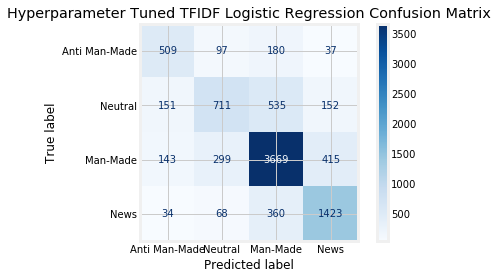

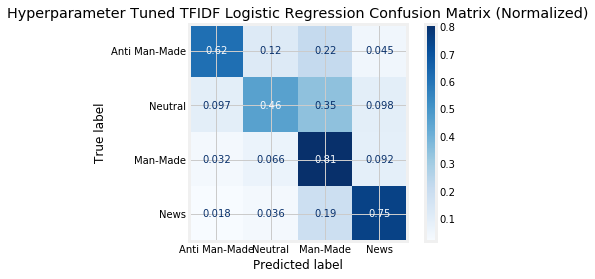

In [119]:
# Plot non-normalized confusion matrix
titles_options = [("Hyperparameter Tuned TFIDF Logistic Regression Confusion Matrix", None),
                  ("Hyperparameter Tuned TFIDF Logistic Regression Confusion Matrix (Normalized)", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(rand_lr_final_3, tfidf_test_df, y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

# Pickling Best Model

## Training on Whole Dataset

In [8]:
data = pd.read_csv('./data_collection/prepared_twitter_sentiment_data.csv', index_col=0)

# Drop 31 rows with missing message column
data.dropna(inplace=True)

In [9]:
# Instantiate vectorizer
tfidf = TfidfVectorizer(ngram_range= (1,1))
# Fit to training data
tfidf_whole = tfidf.fit_transform(data.message)

In [11]:
import pickle

In [12]:
pickle_vec = open("tfidf.pickle","wb")
pickle.dump(tfidf_whole, pickle_vec)
pickle_vec.close()

In [13]:
tfidf_whole

<43912x26067 sparse matrix of type '<class 'numpy.float64'>'
	with 409576 stored elements in Compressed Sparse Row format>

In [14]:
# Convert vectors to dataframe
tfidf_whole_df = pd.DataFrame.sparse.from_spmatrix(
    tfidf_whole, columns=tfidf.get_feature_names())

In [15]:
best_overall_model = LogisticRegression(C=70, class_weight='balanced', max_iter=300, random_state=42)

best_overall_model.fit(tfidf_whole_df, data.sentiment)

LogisticRegression(C=70, class_weight='balanced', max_iter=300, random_state=42)

### Pickling Model

In [16]:
import pickle

In [17]:
pickle_out = open("best_model.pickle","wb")
pickle.dump(best_overall_model, pickle_out)
pickle_out.close()